# This notebook includes most of our main experiments. 

In [1]:
import numpy as np
import pandas as pd
import math
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from catboost import Pool, CatBoostClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import SimpleRNN
from transformers import TFBertModel, BertConfig
import matplotlib.pyplot as plt

2022-06-15 21:00:10.274696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 21:00:10.274720: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# <font color=#FF0000> Data preprocess (w/o group)</font> 	

In [2]:
train_data = pd.read_csv('train.csv')
train_label = pd.read_csv('training-label.csv')
test_data = pd.read_csv('test.csv')
train_data

,mac_hash,sniffer_loc,created_time
0,0003ae8541d0e925fcee242287e2ad27,11,2018-12-07 16:48:08
1,00078611037990f7f36b722f22595fe7,3,2018-12-07 16:29:35
2,00078611037990f7f36b722f22595fe7,2,2018-12-07 16:30:41
3,00078611037990f7f36b722f22595fe7,4,2018-12-07 16:37:06
4,00078611037990f7f36b722f22595fe7,8,2018-12-07 16:37:07
...,...,...,...
41635,fff2ca0333532d6348d5b4fa39028dd4,3,2018-12-07 18:37:37
41636,fff2ca0333532d6348d5b4fa39028dd4,13,2018-12-07 18:47:53
41637,fff2ca0333532d6348d5b4fa39028dd4,12,2018-12-07 18:47:53
41638,fff2ca0333532d6348d5b4fa39028dd4,11,2018-12-07 18:47:54


In [3]:
id_list = train_label['mac_hash']
label_list = train_label['label']

id_dict = {m: [] for m in id_list}

# label_dict
label_dict = dict()

for i, val in enumerate(id_list):
    label_dict[val] = int(label_list[i])

for data in list(train_data.values):
    loc = data[1]
    id_dict[data[0]].append(loc)

for k, v in id_dict.items():
    if len(v) != 14:
        id_dict[k] = [0] * (14 - len(v)) + v
    id_dict[k].append(label_dict[k])

In [4]:
data = np.array(list(id_dict.values()))
X_train = data[:,:-1]
y_train = data[:,-1]

In [5]:
sample = pd.read_csv('submit_samples.csv')

id_list_test = sample['mac_hash']

id_dict_test = {m: [] for m in id_list_test}

# label_dict
label_dict_test = dict()

for data in list(test_data.values):
    loc = data[1]
    id_dict_test[data[0]].append(loc)

for k, v in id_dict_test.items():
    if len(v) != 14:
        id_dict_test[k] = [0] * (14 - len(v)) + v

In [6]:
X_test = np.array(list(id_dict_test.values()))

# <font color=#FF0000> Random Forest (w/o group)</font> 	

### Training (with cross validation)

In [7]:
model = RandomForestClassifier(n_estimators=500, criterion='gini')
result = cross_validate(model, X_train, y_train, cv=5, verbose=3, n_jobs=6)
print('Cross validation mean accuracy:', result['test_score'].mean())

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Cross validation mean accuracy: 0.9535854466727816


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.9s finished


### Training (train with  whole training set)

In [8]:
model = RandomForestClassifier(n_estimators=500, criterion='gini')
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_train)
y_pred = model.predict(X_train)

print('Training set accuracy:', accuracy_score(y_train, y_pred))

Training set accuracy: 1.0


### Test set inference

In [9]:
y_prob = model.predict_proba(X_test)
y_prob

array([[0.174, 0.232, 0.594, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.016, 0.984],
       [1.   , 0.   , 0.   , 0.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.072, 0.004, 0.924, 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   , 0.   ]])

In [10]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,0.174,0.232,0.594,0.000,0.000
1,86e644b498922f3a2fd0e6e1a1525de3,0.000,0.000,0.000,0.016,0.984
2,691662b04ee08015062d901a4c5628b1,1.000,0.000,0.000,0.000,0.000
3,52b5c510a28774237f4f118764c2ed6f,0.000,1.000,0.000,0.000,0.000
4,9f3c995e53d109f532056b6eae29a0b5,0.002,0.214,0.776,0.004,0.004
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,1.000,0.000,0.000,0.000,0.000
3425,f1c8781e701e89068fa0b8a62ecbc564,0.000,0.000,0.010,0.054,0.936
3426,646136b402e136422466a2acd8636630,1.000,0.000,0.000,0.000,0.000
3427,c7bea6491029f86ab3d1f0f9b599ca2c,0.072,0.004,0.924,0.000,0.000


In [11]:
output.to_csv("output_RandomForest.csv", index=False)

# <font color=#FF0000> Catboost (w/o group)</font> 	

### Training (with cross validation)

In [12]:
model = CatBoostClassifier(iterations=1000,learning_rate=0.1,max_depth=7,verbose=100,
                           early_stopping_rounds=500,task_type='GPU',eval_metric='AUC')

result = cross_validate(model, X_train, y_train, cv=5, verbose=3)
print('Cross validation mean accuracy:', result['test_score'].mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 5.73ms	remaining: 5.72s
100:	total: 487ms	remaining: 4.33s
200:	total: 927ms	remaining: 3.68s
300:	total: 1.36s	remaining: 3.17s
400:	total: 1.8s	remaining: 2.69s
500:	total: 2.23s	remaining: 2.23s
600:	total: 2.67s	remaining: 1.77s
700:	total: 3.11s	remaining: 1.32s
800:	total: 3.54s	remaining: 881ms
900:	total: 3.98s	remaining: 438ms
999:	total: 4.42s	remaining: 0us
[CV] END ......................................., score=0.958 total time=   4.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 6.05ms	remaining: 6.05s
100:	total: 441ms	remaining: 3.93s
200:	total: 829ms	remaining: 3.29s
300:	total: 1.27s	remaining: 2.94s
400:	total: 1.66s	remaining: 2.49s
500:	total: 2.1s	remaining: 2.09s
600:	total: 2.56s	remaining: 1.7s
700:	total: 2.95s	remaining: 1.26s
800:	total: 3.41s	remaining: 847ms
900:	total: 3.81s	remaining: 418ms
999:	total: 4.21s	remaining: 0us
[CV] END ......................................., score=0.965 total time=   4.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 5.94ms	remaining: 5.94s
100:	total: 426ms	remaining: 3.79s
200:	total: 887ms	remaining: 3.53s
300:	total: 1.28s	remaining: 2.97s
400:	total: 1.68s	remaining: 2.51s
500:	total: 2.08s	remaining: 2.07s
600:	total: 2.48s	remaining: 1.64s
700:	total: 2.9s	remaining: 1.24s
800:	total: 3.35s	remaining: 831ms
900:	total: 3.77s	remaining: 415ms
999:	total: 4.19s	remaining: 0us
[CV] END ......................................., score=0.965 total time=   4.6s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 5.98ms	remaining: 5.97s
100:	total: 458ms	remaining: 4.08s
200:	total: 863ms	remaining: 3.43s
300:	total: 1.31s	remaining: 3.05s
400:	total: 1.71s	remaining: 2.56s
500:	total: 2.13s	remaining: 2.13s
600:	total: 2.59s	remaining: 1.72s
700:	total: 3.05s	remaining: 1.3s
800:	total: 3.49s	remaining: 868ms
900:	total: 3.9s	remaining: 429ms
999:	total: 4.34s	remaining: 0us
[CV] END ......................................., score=0.962 total time=   4.7s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 5.66ms	remaining: 5.65s
100:	total: 429ms	remaining: 3.82s
200:	total: 851ms	remaining: 3.38s
300:	total: 1.27s	remaining: 2.95s
400:	total: 1.68s	remaining: 2.51s
500:	total: 2.13s	remaining: 2.12s
600:	total: 2.58s	remaining: 1.71s
700:	total: 3s	remaining: 1.28s
800:	total: 3.44s	remaining: 853ms
900:	total: 3.84s	remaining: 422ms
999:	total: 4.26s	remaining: 0us
[CV] END ......................................., score=0.963 total time=   4.7s
Cross validation mean accuracy: 0.9624946288537973


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.5s finished


### Training (train with  whole training set)

In [13]:
model = CatBoostClassifier(iterations=1000,learning_rate=0.1,max_depth=7,verbose=100,
                           early_stopping_rounds=500,task_type='GPU',eval_metric='AUC')
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_train)
y_pred = model.predict(X_train)

print('Training set accuracy:', accuracy_score(y_train, y_pred))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 4.57ms	remaining: 4.57s
100:	total: 406ms	remaining: 3.61s
200:	total: 837ms	remaining: 3.33s
300:	total: 1.29s	remaining: 3s
400:	total: 1.72s	remaining: 2.57s
500:	total: 2.12s	remaining: 2.11s
600:	total: 2.57s	remaining: 1.7s
700:	total: 2.99s	remaining: 1.27s
800:	total: 3.44s	remaining: 854ms
900:	total: 3.87s	remaining: 425ms
999:	total: 4.28s	remaining: 0us
Training set accuracy: 1.0


### Test set inference

In [14]:
y_prob = model.predict_proba(X_test)
y_prob

array([[1.17920453e-01, 1.65108228e-02, 8.64814066e-01, 6.35726734e-04,
        1.18931508e-04],
       [2.20586851e-06, 1.60560543e-06, 7.58320423e-05, 4.58110866e-03,
        9.95339248e-01],
       [9.99988129e-01, 1.09094005e-05, 4.48668365e-07, 4.27234932e-07,
        8.55970272e-08],
       ...,
       [9.99814317e-01, 1.82633354e-04, 2.09564183e-06, 8.62817252e-07,
        9.10079788e-08],
       [1.12559751e-02, 6.79574819e-05, 9.88651026e-01, 2.04516712e-05,
        4.59012792e-06],
       [9.99821657e-01, 1.76760597e-04, 1.47514272e-07, 1.31998981e-06,
        1.14822247e-07]])

In [15]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,0.117920,0.016511,8.648141e-01,6.357267e-04,1.189315e-04
1,86e644b498922f3a2fd0e6e1a1525de3,0.000002,0.000002,7.583204e-05,4.581109e-03,9.953392e-01
2,691662b04ee08015062d901a4c5628b1,0.999988,0.000011,4.486684e-07,4.272349e-07,8.559703e-08
3,52b5c510a28774237f4f118764c2ed6f,0.002449,0.997549,5.361618e-07,1.487764e-06,1.237406e-07
4,9f3c995e53d109f532056b6eae29a0b5,0.000377,0.066536,9.302961e-01,1.792449e-03,9.980440e-04
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,0.999814,0.000185,1.904194e-07,1.165337e-06,1.026893e-07
3425,f1c8781e701e89068fa0b8a62ecbc564,0.000011,0.000020,6.425098e-04,1.080604e-02,9.885204e-01
3426,646136b402e136422466a2acd8636630,0.999814,0.000183,2.095642e-06,8.628173e-07,9.100798e-08
3427,c7bea6491029f86ab3d1f0f9b599ca2c,0.011256,0.000068,9.886510e-01,2.045167e-05,4.590128e-06


In [16]:
output.to_csv("output_Catboost.csv", index=False)

# <font color=#FF0000> LSTM (w/o group)</font> 	

### Training (with validation set spiltted from training set)

In [17]:
model = Sequential()
model.add(LSTM(units = 20, activation='relu', return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 20)            1760      
                                                                 
 dropout (Dropout)           (None, 14, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,877
Trainable params: 5,877
Non-trainabl

2022-06-15 21:00:46.001854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 21:00:46.002053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 21:00:46.002102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-15 21:00:46.002148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-15 21:00:46.002192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [18]:
model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy',  metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 128, verbose = 1, validation_split=0.1)

Epoch 1/200
49/49 [==============================] - 2s 13ms/step - loss: 1.3574 - acc: 0.5191 - val_loss: 1.0115 - val_acc: 0.7126
Epoch 2/200
49/49 [==============================] - 0s 6ms/step - loss: 0.7876 - acc: 0.6874 - val_loss: 0.4860 - val_acc: 0.7816
Epoch 3/200
49/49 [==============================] - 0s 6ms/step - loss: 0.5685 - acc: 0.7563 - val_loss: 0.4119 - val_acc: 0.8003
Epoch 4/200
49/49 [==============================] - 0s 6ms/step - loss: 0.4941 - acc: 0.7884 - val_loss: 0.3816 - val_acc: 0.8376
Epoch 5/200
49/49 [==============================] - 0s 6ms/step - loss: 0.4597 - acc: 0.8106 - val_loss: 0.3425 - val_acc: 0.8664
Epoch 6/200
49/49 [==============================] - 0s 6ms/step - loss: 0.4368 - acc: 0.8159 - val_loss: 0.3082 - val_acc: 0.8937
Epoch 7/200
49/49 [==============================] - 0s 6ms/step - loss: 0.3997 - acc: 0.8328 - val_loss: 0.2791 - val_acc: 0.8951
Epoch 8/200
49/49 [==============================] - 0s 6ms/step - loss: 0.3748 - 

Epoch 125/200
49/49 [==============================] - 0s 6ms/step - loss: 0.1497 - acc: 0.9411 - val_loss: 0.1271 - val_acc: 0.9569
Epoch 126/200
49/49 [==============================] - 0s 6ms/step - loss: 0.1497 - acc: 0.9422 - val_loss: 0.1349 - val_acc: 0.9497
Epoch 127/200
49/49 [==============================] - 0s 6ms/step - loss: 0.1512 - acc: 0.9452 - val_loss: 0.1408 - val_acc: 0.9483
Epoch 128/200
49/49 [==============================] - 0s 6ms/step - loss: 0.1532 - acc: 0.9417 - val_loss: 0.1365 - val_acc: 0.9411
Epoch 129/200
49/49 [==============================] - 0s 6ms/step - loss: 0.1612 - acc: 0.9436 - val_loss: 0.1466 - val_acc: 0.9425
Epoch 130/200
49/49 [==============================] - 0s 6ms/step - loss: 0.1477 - acc: 0.9452 - val_loss: 0.1415 - val_acc: 0.9511
Epoch 131/200
49/49 [==============================] - 0s 6ms/step - loss: 0.1518 - acc: 0.9408 - val_loss: 0.1326 - val_acc: 0.9440
Epoch 132/200
49/49 [==============================] - 0s 6ms/step - 

Text(0.5, 1.0, 'Training - Loss Function')

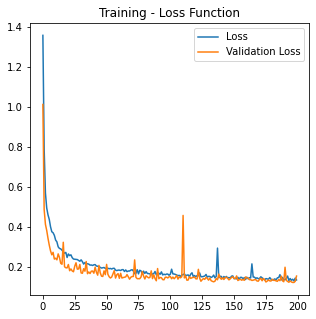

In [19]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Training (train with  whole training set)

In [20]:
model = Sequential()
model.add(LSTM(units = 20, activation='relu', return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy',  metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 128, verbose = 1)

Epoch 1/200
55/55 [==============================] - 2s 6ms/step - loss: 1.3647 - acc: 0.5465
Epoch 2/200
55/55 [==============================] - 0s 6ms/step - loss: 0.8353 - acc: 0.6538
Epoch 3/200
55/55 [==============================] - 0s 6ms/step - loss: 0.7009 - acc: 0.6869
Epoch 4/200
55/55 [==============================] - 0s 6ms/step - loss: 0.6358 - acc: 0.7181
Epoch 5/200
55/55 [==============================] - 0s 6ms/step - loss: 0.5917 - acc: 0.7448
Epoch 6/200
55/55 [==============================] - 0s 6ms/step - loss: 0.5445 - acc: 0.7665
Epoch 7/200
55/55 [==============================] - 0s 6ms/step - loss: 0.4886 - acc: 0.7998
Epoch 8/200
55/55 [==============================] - 0s 6ms/step - loss: 0.4322 - acc: 0.8166
Epoch 9/200
55/55 [==============================] - 0s 6ms/step - loss: 0.4061 - acc: 0.8368
Epoch 10/200
55/55 [==============================] - 0s 6ms/step - loss: 0.3920 - acc: 0.8362
Epoch 11/200
55/55 [==============================] - 0s 6m

55/55 [==============================] - 0s 6ms/step - loss: 0.1437 - acc: 0.9440
Epoch 173/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1404 - acc: 0.9470
Epoch 174/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1423 - acc: 0.9460
Epoch 175/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1353 - acc: 0.9467
Epoch 176/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1342 - acc: 0.9473
Epoch 177/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1414 - acc: 0.9442
Epoch 178/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1383 - acc: 0.9442
Epoch 179/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1344 - acc: 0.9480
Epoch 180/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1381 - acc: 0.9465
Epoch 181/200
55/55 [==============================] - 0s 6ms/step - loss: 0.1408 - acc: 0.9447
Epoch 182/200
55/55 [==============================] -

Text(0.5, 1.0, 'Training - Loss Function')

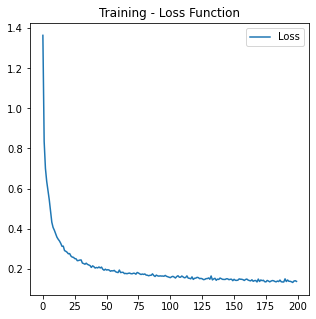

In [21]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Test set inference

In [22]:
y_prob = model.predict(X_test)
y_prob

108/108 [==============================] - 0s 2ms/step


array([[7.9212030e-03, 1.7071757e-02, 9.7500420e-01, 2.8124256e-07,
        2.6210228e-06],
       [5.6985944e-10, 1.5294478e-05, 1.7466332e-06, 1.1778819e-02,
        9.8820418e-01],
       [9.9999994e-01, 4.4733679e-16, 2.2780045e-14, 9.4090610e-36,
        0.0000000e+00],
       ...,
       [9.9993110e-01, 6.1152074e-05, 7.7730574e-06, 8.1523669e-15,
        5.8316567e-16],
       [1.9796031e-02, 3.7728788e-04, 9.7982669e-01, 3.0075397e-11,
        3.2104086e-10],
       [1.0000000e+00, 4.8242114e-21, 1.0268602e-20, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [23]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,7.921203e-03,1.707176e-02,9.750042e-01,2.812426e-07,2.621023e-06
1,86e644b498922f3a2fd0e6e1a1525de3,5.698594e-10,1.529448e-05,1.746633e-06,1.177882e-02,9.882042e-01
2,691662b04ee08015062d901a4c5628b1,9.999999e-01,4.473368e-16,2.278004e-14,9.409061e-36,0.000000e+00
3,52b5c510a28774237f4f118764c2ed6f,2.721664e-03,9.972550e-01,1.870805e-05,4.653631e-06,6.256593e-10
4,9f3c995e53d109f532056b6eae29a0b5,7.714346e-04,2.712694e-01,7.279003e-01,4.724672e-05,1.155017e-05
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,1.000000e+00,1.385725e-18,1.984960e-18,4.387067e-37,0.000000e+00
3425,f1c8781e701e89068fa0b8a62ecbc564,2.944204e-08,1.782065e-04,2.747556e-05,1.256109e-02,9.872332e-01
3426,646136b402e136422466a2acd8636630,9.999311e-01,6.115207e-05,7.773057e-06,8.152367e-15,5.831657e-16
3427,c7bea6491029f86ab3d1f0f9b599ca2c,1.979603e-02,3.772879e-04,9.798267e-01,3.007540e-11,3.210409e-10


In [24]:
output.to_csv("output_LSTM.csv", index=False)

# <font color=#FF0000> RNN (w/o group)</font> 	

### Training (with validation set spiltted from training set)

In [25]:
model = Sequential()#Adding the first SimpleRNN layer and some Dropout regularisation
model.add(SimpleRNN(units = 30, activation='relu', return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))# Adding a second SimpleRNN layer and some Dropout regularisation
model.add(SimpleRNN(units = 30, activation='relu', return_sequences=True))
model.add(Dropout(0.2))# Adding a third SimpleRNN layer and some Dropout regularisation
model.add(SimpleRNN(units = 30, activation='relu'))
model.add(Dense(units = 5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 14, 30)            960       
                                                                 
 dropout_4 (Dropout)         (None, 14, 30)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 14, 30)            1830      
                                                                 
 dropout_5 (Dropout)         (None, 14, 30)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense_4 (Dense)             (None, 5)                 155       
                                                                 
Total params: 4,775
Trainable params: 4,775
Non-traina

In [26]:
model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy',  metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 128, verbose = 1, validation_split=0.1)

Epoch 1/200
49/49 [==============================] - 2s 10ms/step - loss: 1.3341 - acc: 0.5207 - val_loss: 0.9029 - val_acc: 0.6408
Epoch 2/200
49/49 [==============================] - 0s 5ms/step - loss: 0.8565 - acc: 0.6411 - val_loss: 0.6453 - val_acc: 0.7586
Epoch 3/200
49/49 [==============================] - 0s 5ms/step - loss: 0.6744 - acc: 0.7009 - val_loss: 0.5218 - val_acc: 0.7902
Epoch 4/200
49/49 [==============================] - 0s 5ms/step - loss: 0.5852 - acc: 0.7378 - val_loss: 0.5043 - val_acc: 0.8089
Epoch 5/200
49/49 [==============================] - 0s 5ms/step - loss: 0.5266 - acc: 0.7659 - val_loss: 0.4476 - val_acc: 0.8448
Epoch 6/200
49/49 [==============================] - 0s 5ms/step - loss: 0.4810 - acc: 0.7939 - val_loss: 0.3901 - val_acc: 0.8520
Epoch 7/200
49/49 [==============================] - 0s 5ms/step - loss: 0.4548 - acc: 0.8119 - val_loss: 0.4225 - val_acc: 0.8376
Epoch 8/200
49/49 [==============================] - 0s 5ms/step - loss: 0.4244 - 

Epoch 125/200
49/49 [==============================] - 0s 5ms/step - loss: 0.1218 - acc: 0.9515 - val_loss: 0.1620 - val_acc: 0.9397
Epoch 126/200
49/49 [==============================] - 0s 5ms/step - loss: 0.1337 - acc: 0.9470 - val_loss: 0.1185 - val_acc: 0.9598
Epoch 127/200
49/49 [==============================] - 0s 5ms/step - loss: 0.1244 - acc: 0.9508 - val_loss: 0.1180 - val_acc: 0.9626
Epoch 128/200
49/49 [==============================] - 0s 5ms/step - loss: 0.1244 - acc: 0.9539 - val_loss: 0.1178 - val_acc: 0.9526
Epoch 129/200
49/49 [==============================] - 0s 5ms/step - loss: 0.1234 - acc: 0.9535 - val_loss: 0.1147 - val_acc: 0.9598
Epoch 130/200
49/49 [==============================] - 0s 5ms/step - loss: 0.1314 - acc: 0.9492 - val_loss: 0.1190 - val_acc: 0.9526
Epoch 131/200
49/49 [==============================] - 0s 5ms/step - loss: 0.1290 - acc: 0.9519 - val_loss: 0.1419 - val_acc: 0.9483
Epoch 132/200
49/49 [==============================] - 0s 5ms/step - 

Text(0.5, 1.0, 'Training - Loss Function')

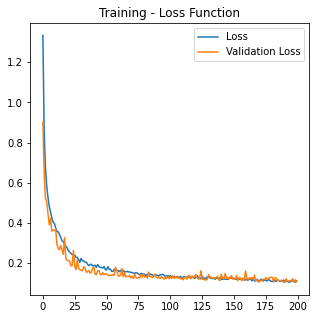

In [27]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Training (train with  whole training set)

In [28]:
model = Sequential()#Adding the first SimpleRNN layer and some Dropout regularisation
model.add(SimpleRNN(units = 30, activation='relu', return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))# Adding a second SimpleRNN layer and some Dropout regularisation
model.add(SimpleRNN(units = 30, activation='relu', return_sequences=True))
model.add(Dropout(0.2))# Adding a third SimpleRNN layer and some Dropout regularisation
model.add(SimpleRNN(units = 30, activation='relu'))
model.add(Dense(units = 5, activation='softmax'))

model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy',  metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 128, verbose = 1)

Epoch 1/200
55/55 [==============================] - 2s 5ms/step - loss: 1.3291 - acc: 0.5189
Epoch 2/200
55/55 [==============================] - 0s 5ms/step - loss: 0.7583 - acc: 0.6676
Epoch 3/200
55/55 [==============================] - 0s 5ms/step - loss: 0.5770 - acc: 0.7288
Epoch 4/200
55/55 [==============================] - 0s 5ms/step - loss: 0.5224 - acc: 0.7642
Epoch 5/200
55/55 [==============================] - 0s 5ms/step - loss: 0.4706 - acc: 0.7957
Epoch 6/200
55/55 [==============================] - 0s 5ms/step - loss: 0.4498 - acc: 0.8050
Epoch 7/200
55/55 [==============================] - 0s 5ms/step - loss: 0.4243 - acc: 0.8227
Epoch 8/200
55/55 [==============================] - 0s 5ms/step - loss: 0.3949 - acc: 0.8323
Epoch 9/200
55/55 [==============================] - 0s 5ms/step - loss: 0.3755 - acc: 0.8416
Epoch 10/200
55/55 [==============================] - 0s 5ms/step - loss: 0.3581 - acc: 0.8510
Epoch 11/200
55/55 [==============================] - 0s 5m

55/55 [==============================] - 0s 5ms/step - loss: 0.1200 - acc: 0.9532
Epoch 173/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1210 - acc: 0.9532
Epoch 174/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1178 - acc: 0.9559
Epoch 175/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1209 - acc: 0.9513
Epoch 176/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1198 - acc: 0.9529
Epoch 177/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1130 - acc: 0.9565
Epoch 178/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1201 - acc: 0.9550
Epoch 179/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1210 - acc: 0.9523
Epoch 180/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1158 - acc: 0.9526
Epoch 181/200
55/55 [==============================] - 0s 5ms/step - loss: 0.1167 - acc: 0.9553
Epoch 182/200
55/55 [==============================] -

Text(0.5, 1.0, 'Training - Loss Function')

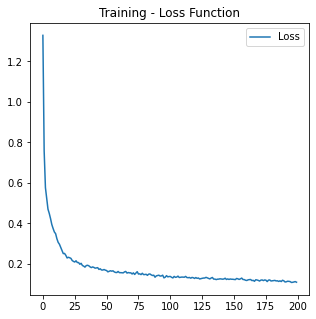

In [29]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Test set inference

In [30]:
y_prob = model.predict(X_test)
y_prob

108/108 [==============================] - 0s 1ms/step


array([[6.09488860e-02, 4.86623915e-03, 9.34169531e-01, 1.43453944e-05,
        9.82873985e-07],
       [1.87880706e-26, 9.08546086e-11, 4.38092829e-05, 5.80884865e-04,
        9.99375284e-01],
       [9.99999940e-01, 7.91249932e-14, 8.63226117e-14, 1.49177453e-24,
        4.60048202e-30],
       ...,
       [9.99999881e-01, 6.08180386e-08, 3.46723148e-08, 1.35479515e-14,
        1.58159195e-21],
       [7.33036315e-03, 8.50714514e-06, 9.92661119e-01, 1.06530426e-13,
        5.31296969e-15],
       [1.00000000e+00, 5.47971113e-10, 4.02268756e-12, 3.12057890e-17,
        1.48731488e-23]], dtype=float32)

In [31]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,6.094889e-02,4.866239e-03,9.341695e-01,1.434539e-05,9.828740e-07
1,86e644b498922f3a2fd0e6e1a1525de3,1.878807e-26,9.085461e-11,4.380928e-05,5.808849e-04,9.993753e-01
2,691662b04ee08015062d901a4c5628b1,9.999999e-01,7.912499e-14,8.632261e-14,1.491775e-24,4.600482e-30
3,52b5c510a28774237f4f118764c2ed6f,1.861883e-03,9.980972e-01,8.035893e-06,3.280407e-05,3.557997e-16
4,9f3c995e53d109f532056b6eae29a0b5,4.105323e-08,1.495906e-03,9.983988e-01,3.995387e-05,6.525678e-05
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,1.000000e+00,2.974770e-10,3.287433e-12,1.114474e-17,5.139043e-24
3425,f1c8781e701e89068fa0b8a62ecbc564,1.937212e-23,1.269270e-08,3.701468e-05,1.126766e-03,9.988362e-01
3426,646136b402e136422466a2acd8636630,9.999999e-01,6.081804e-08,3.467231e-08,1.354795e-14,1.581592e-21
3427,c7bea6491029f86ab3d1f0f9b599ca2c,7.330363e-03,8.507145e-06,9.926611e-01,1.065304e-13,5.312970e-15


In [32]:
output.to_csv("output_RNN.csv", index=False)

# <font color=#FF0000> Transformer Bert (w/o group)</font> 	

### Training (with validation set spiltted from training set)

In [33]:
y_train_onehot = np.eye(5)[y_train]
y_train_onehot

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [34]:
config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_seq (InputLayer)         [(None, 14)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 14)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  40160       ['input_seq[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 14,                                            

In [35]:
X_mask = np.ones((len(X_train),14))
history = model.fit([X_train, X_mask], y_train_onehot, batch_size=1024, epochs=500, validation_split=0.1)

Epoch 1/500
7/7 [==============================] - 14s 558ms/step - loss: 1.6325 - accuracy: 0.2646 - val_loss: 1.4857 - val_accuracy: 0.4023
Epoch 2/500
7/7 [==============================] - 2s 237ms/step - loss: 1.4855 - accuracy: 0.3883 - val_loss: 1.4406 - val_accuracy: 0.4023
Epoch 3/500
7/7 [==============================] - 2s 236ms/step - loss: 1.4227 - accuracy: 0.3896 - val_loss: 1.3116 - val_accuracy: 0.4368
Epoch 4/500
7/7 [==============================] - 2s 236ms/step - loss: 1.2666 - accuracy: 0.5307 - val_loss: 1.0727 - val_accuracy: 0.6322
Epoch 5/500
7/7 [==============================] - 2s 239ms/step - loss: 1.0398 - accuracy: 0.6222 - val_loss: 0.9159 - val_accuracy: 0.6552
Epoch 6/500
7/7 [==============================] - 2s 237ms/step - loss: 0.8983 - accuracy: 0.6467 - val_loss: 0.8151 - val_accuracy: 0.6911
Epoch 7/500
7/7 [==============================] - 2s 237ms/step - loss: 0.8008 - accuracy: 0.6957 - val_loss: 0.7356 - val_accuracy: 0.7428
Epoch 8/500


Epoch 109/500
7/7 [==============================] - 2s 237ms/step - loss: 0.0739 - accuracy: 0.9762 - val_loss: 0.0724 - val_accuracy: 0.9655
Epoch 110/500
7/7 [==============================] - 2s 236ms/step - loss: 0.0765 - accuracy: 0.9756 - val_loss: 0.0800 - val_accuracy: 0.9626
Epoch 111/500
7/7 [==============================] - 2s 236ms/step - loss: 0.0880 - accuracy: 0.9721 - val_loss: 0.0661 - val_accuracy: 0.9698
Epoch 112/500
7/7 [==============================] - 2s 238ms/step - loss: 0.0806 - accuracy: 0.9741 - val_loss: 0.0656 - val_accuracy: 0.9741
Epoch 113/500
7/7 [==============================] - 2s 238ms/step - loss: 0.0876 - accuracy: 0.9717 - val_loss: 0.0589 - val_accuracy: 0.9727
Epoch 114/500
7/7 [==============================] - 2s 237ms/step - loss: 0.0754 - accuracy: 0.9740 - val_loss: 0.0786 - val_accuracy: 0.9727
Epoch 115/500
7/7 [==============================] - 2s 241ms/step - loss: 0.0753 - accuracy: 0.9751 - val_loss: 0.0576 - val_accuracy: 0.9784

7/7 [==============================] - 2s 236ms/step - loss: 0.0578 - accuracy: 0.9820 - val_loss: 0.0401 - val_accuracy: 0.9842
Epoch 224/500
7/7 [==============================] - 2s 236ms/step - loss: 0.0549 - accuracy: 0.9839 - val_loss: 0.0402 - val_accuracy: 0.9828
Epoch 225/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0573 - accuracy: 0.9815 - val_loss: 0.0450 - val_accuracy: 0.9856
Epoch 226/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0516 - accuracy: 0.9844 - val_loss: 0.0384 - val_accuracy: 0.9871
Epoch 227/500
7/7 [==============================] - 2s 235ms/step - loss: 0.0565 - accuracy: 0.9823 - val_loss: 0.0410 - val_accuracy: 0.9885
Epoch 228/500
7/7 [==============================] - 2s 237ms/step - loss: 0.0565 - accuracy: 0.9832 - val_loss: 0.0422 - val_accuracy: 0.9828
Epoch 229/500
7/7 [==============================] - 2s 236ms/step - loss: 0.0577 - accuracy: 0.9821 - val_loss: 0.0482 - val_accuracy: 0.9799
Epoch 230/500

7/7 [==============================] - 2s 234ms/step - loss: 0.0500 - accuracy: 0.9845 - val_loss: 0.0425 - val_accuracy: 0.9856
Epoch 338/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0493 - accuracy: 0.9845 - val_loss: 0.0394 - val_accuracy: 0.9885
Epoch 339/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0523 - accuracy: 0.9836 - val_loss: 0.0384 - val_accuracy: 0.9856
Epoch 340/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0534 - accuracy: 0.9837 - val_loss: 0.0391 - val_accuracy: 0.9828
Epoch 341/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0523 - accuracy: 0.9837 - val_loss: 0.0369 - val_accuracy: 0.9885
Epoch 342/500
7/7 [==============================] - 2s 236ms/step - loss: 0.0526 - accuracy: 0.9850 - val_loss: 0.0403 - val_accuracy: 0.9828
Epoch 343/500
7/7 [==============================] - 2s 305ms/step - loss: 0.0528 - accuracy: 0.9845 - val_loss: 0.0352 - val_accuracy: 0.9871
Epoch 344/500

7/7 [==============================] - 2s 235ms/step - loss: 0.0474 - accuracy: 0.9834 - val_loss: 0.0302 - val_accuracy: 0.9871
Epoch 452/500
7/7 [==============================] - 2s 237ms/step - loss: 0.0433 - accuracy: 0.9859 - val_loss: 0.0288 - val_accuracy: 0.9914
Epoch 453/500
7/7 [==============================] - 2s 235ms/step - loss: 0.0465 - accuracy: 0.9852 - val_loss: 0.0334 - val_accuracy: 0.9871
Epoch 454/500
7/7 [==============================] - 2s 236ms/step - loss: 0.0460 - accuracy: 0.9871 - val_loss: 0.0311 - val_accuracy: 0.9899
Epoch 455/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0440 - accuracy: 0.9863 - val_loss: 0.0309 - val_accuracy: 0.9899
Epoch 456/500
7/7 [==============================] - 2s 234ms/step - loss: 0.0433 - accuracy: 0.9887 - val_loss: 0.0400 - val_accuracy: 0.9842
Epoch 457/500
7/7 [==============================] - 2s 235ms/step - loss: 0.0466 - accuracy: 0.9840 - val_loss: 0.0429 - val_accuracy: 0.9856
Epoch 458/500

Text(0.5, 1.0, 'Training - Loss Function')

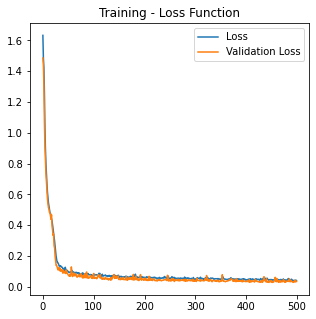

In [36]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Training (train with  whole training set)

In [37]:
config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

X_mask = np.ones((len(X_train),14))
history = model.fit([X_train, X_mask], y_train_onehot, batch_size=1024, epochs=500)
model.save_weights('./checkpoint_Bert/Transformer_Bert')

Epoch 1/500
7/7 [==============================] - 12s 254ms/step - loss: 1.6239 - accuracy: 0.2470
Epoch 2/500
7/7 [==============================] - 2s 253ms/step - loss: 1.5023 - accuracy: 0.3878
Epoch 3/500
7/7 [==============================] - 2s 252ms/step - loss: 1.3894 - accuracy: 0.4595
Epoch 4/500
7/7 [==============================] - 2s 252ms/step - loss: 1.1518 - accuracy: 0.6078
Epoch 5/500
7/7 [==============================] - 2s 251ms/step - loss: 0.9672 - accuracy: 0.6412
Epoch 6/500
7/7 [==============================] - 2s 251ms/step - loss: 0.8756 - accuracy: 0.6704
Epoch 7/500
7/7 [==============================] - 2s 252ms/step - loss: 0.8074 - accuracy: 0.6834
Epoch 8/500
7/7 [==============================] - 2s 251ms/step - loss: 0.7455 - accuracy: 0.7071
Epoch 9/500
7/7 [==============================] - 2s 252ms/step - loss: 0.6777 - accuracy: 0.7392
Epoch 10/500
7/7 [==============================] - 2s 252ms/step - loss: 0.6236 - accuracy: 0.7520
Epoch 11

Epoch 78/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0788 - accuracy: 0.9749
Epoch 79/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0773 - accuracy: 0.9770
Epoch 80/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0776 - accuracy: 0.9746
Epoch 81/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0772 - accuracy: 0.9737
Epoch 82/500
7/7 [==============================] - 2s 250ms/step - loss: 0.0715 - accuracy: 0.9782
Epoch 83/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0714 - accuracy: 0.9767
Epoch 84/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0713 - accuracy: 0.9786
Epoch 85/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0722 - accuracy: 0.9770
Epoch 86/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0704 - accuracy: 0.9787
Epoch 87/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0718 - accuracy: 0.9766


7/7 [==============================] - 2s 252ms/step - loss: 0.0481 - accuracy: 0.9851
Epoch 241/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0497 - accuracy: 0.9842
Epoch 242/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0482 - accuracy: 0.9861
Epoch 243/500
7/7 [==============================] - 2s 251ms/step - loss: 0.0510 - accuracy: 0.9842
Epoch 244/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0546 - accuracy: 0.9825
Epoch 245/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0497 - accuracy: 0.9840
Epoch 246/500
7/7 [==============================] - 2s 253ms/step - loss: 0.0485 - accuracy: 0.9840
Epoch 247/500
7/7 [==============================] - 2s 250ms/step - loss: 0.0468 - accuracy: 0.9856
Epoch 248/500
7/7 [==============================] - 2s 253ms/step - loss: 0.0448 - accuracy: 0.9865
Epoch 249/500
7/7 [==============================] - 2s 253ms/step - loss: 0.0484 - accuracy: 0.9853
Epoc

7/7 [==============================] - 2s 253ms/step - loss: 0.0366 - accuracy: 0.9882
Epoch 403/500
7/7 [==============================] - 2s 255ms/step - loss: 0.0392 - accuracy: 0.9882
Epoch 404/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0371 - accuracy: 0.9881
Epoch 405/500
7/7 [==============================] - 2s 275ms/step - loss: 0.0387 - accuracy: 0.9875
Epoch 406/500
7/7 [==============================] - 2s 256ms/step - loss: 0.0384 - accuracy: 0.9891
Epoch 407/500
7/7 [==============================] - 2s 254ms/step - loss: 0.0388 - accuracy: 0.9898
Epoch 408/500
7/7 [==============================] - 2s 255ms/step - loss: 0.0374 - accuracy: 0.9888
Epoch 409/500
7/7 [==============================] - 2s 254ms/step - loss: 0.0351 - accuracy: 0.9895
Epoch 410/500
7/7 [==============================] - 2s 252ms/step - loss: 0.0357 - accuracy: 0.9888
Epoch 411/500
7/7 [==============================] - 2s 253ms/step - loss: 0.0372 - accuracy: 0.9882
Epoc

Text(0.5, 1.0, 'Training - Loss Function')

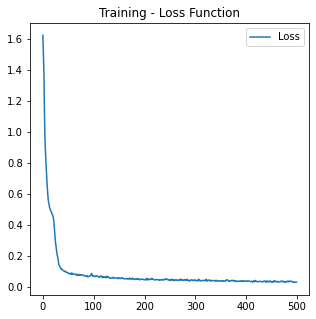

In [38]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Test set inference

In [39]:
X_test_mask = np.ones((len(X_test),14))
y_prob = model.predict([X_test, X_test_mask])
y_prob

108/108 [==============================] - 3s 8ms/step


array([[1.6448775e-02, 3.0260968e-03, 9.8049098e-01, 3.4161436e-05,
        1.0143701e-08],
       [6.6307746e-09, 3.0830529e-07, 2.4225022e-07, 1.8034127e-03,
        9.9819607e-01],
       [9.9998420e-01, 1.4281015e-05, 9.7421076e-09, 1.4540957e-06,
        2.2030476e-12],
       ...,
       [9.9997878e-01, 1.9820520e-05, 8.2963298e-09, 1.4654826e-06,
        2.5373625e-12],
       [2.0826361e-04, 2.2738825e-06, 9.9977356e-01, 1.5801674e-05,
        7.8163553e-10],
       [9.9997580e-01, 2.2477867e-05, 7.8304465e-09, 1.6271752e-06,
        2.6890742e-12]], dtype=float32)

In [40]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,1.644878e-02,3.026097e-03,9.804910e-01,0.000034,1.014370e-08
1,86e644b498922f3a2fd0e6e1a1525de3,6.630775e-09,3.083053e-07,2.422502e-07,0.001803,9.981961e-01
2,691662b04ee08015062d901a4c5628b1,9.999842e-01,1.428101e-05,9.742108e-09,0.000001,2.203048e-12
3,52b5c510a28774237f4f118764c2ed6f,1.278075e-05,9.999846e-01,1.420635e-08,0.000003,2.989767e-08
4,9f3c995e53d109f532056b6eae29a0b5,5.603024e-05,1.705543e-02,9.828635e-01,0.000022,3.136811e-06
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,9.999769e-01,2.151068e-05,7.950217e-09,0.000002,2.632553e-12
3425,f1c8781e701e89068fa0b8a62ecbc564,1.104203e-08,7.250752e-07,2.572630e-07,0.001593,9.984059e-01
3426,646136b402e136422466a2acd8636630,9.999788e-01,1.982052e-05,8.296330e-09,0.000001,2.537362e-12
3427,c7bea6491029f86ab3d1f0f9b599ca2c,2.082636e-04,2.273883e-06,9.997736e-01,0.000016,7.816355e-10


In [41]:
output.to_csv("output_transformer_bert.csv", index=False)

# <font color=#FF0000> Transformer XLNet (w/o group)</font> 	

### Training (with validation set spiltted from training set)

In [42]:
from transformers import XLNetConfig, TFXLNetModel
data = np.array(list(id_dict.values()))
X_train = data[:,:-1]
y_train = data[:,-1]
y_train = np.eye(5)[y_train]


config = XLNetConfig(vocab_size=15, d_model=16, n_layer=8, n_head=4, d_inner=64)

xlnet = TFXLNetModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

embeddings = xlnet(input_seq)[0]
embeddings = embeddings[:, 0]

x = tf.keras.layers.Dense(32, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)
model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_seq (InputLayer)         [(None, 14)]         0           []                               
                                                                                                  
 tfxl_net_model (TFXLNetModel)  TFXLNetModelOutput(  28672       ['input_seq[0][0]']              
                                last_hidden_state=(                                               
                                None, 14, 16),                                                    
                                 mems=((14, None, 1                                               
                                6),                                                               
                                 (14, None, 16),                                            

In [43]:
X_mask = np.ones((len(X_train),14))
history = model.fit([X_train, X_mask], y_train, batch_size=1024, epochs=500, validation_split=0.1)

Epoch 1/500
7/7 [==============================] - 9s 486ms/step - loss: 1.6217 - accuracy: 0.2611 - val_loss: 1.4257 - val_accuracy: 0.4138
Epoch 2/500
7/7 [==============================] - 2s 322ms/step - loss: 1.4688 - accuracy: 0.4116 - val_loss: 1.3783 - val_accuracy: 0.4181
Epoch 3/500
7/7 [==============================] - 2s 323ms/step - loss: 1.3938 - accuracy: 0.4662 - val_loss: 1.2456 - val_accuracy: 0.6509
Epoch 4/500
7/7 [==============================] - 2s 321ms/step - loss: 1.2607 - accuracy: 0.6115 - val_loss: 1.1002 - val_accuracy: 0.6537
Epoch 5/500
7/7 [==============================] - 2s 320ms/step - loss: 1.1113 - accuracy: 0.6344 - val_loss: 0.9643 - val_accuracy: 0.6552
Epoch 6/500
7/7 [==============================] - 2s 321ms/step - loss: 0.9873 - accuracy: 0.6433 - val_loss: 0.8801 - val_accuracy: 0.6739
Epoch 7/500
7/7 [==============================] - 2s 322ms/step - loss: 0.9093 - accuracy: 0.6588 - val_loss: 0.8129 - val_accuracy: 0.6968
Epoch 8/500
7

Epoch 100/500
7/7 [==============================] - 2s 322ms/step - loss: 0.0999 - accuracy: 0.9689 - val_loss: 0.0536 - val_accuracy: 0.9842
Epoch 101/500
7/7 [==============================] - 2s 319ms/step - loss: 0.0916 - accuracy: 0.9708 - val_loss: 0.0559 - val_accuracy: 0.9828
Epoch 102/500
7/7 [==============================] - 2s 321ms/step - loss: 0.0938 - accuracy: 0.9705 - val_loss: 0.0606 - val_accuracy: 0.9856
Epoch 103/500
7/7 [==============================] - 2s 324ms/step - loss: 0.0939 - accuracy: 0.9719 - val_loss: 0.0547 - val_accuracy: 0.9756
Epoch 104/500
7/7 [==============================] - 2s 320ms/step - loss: 0.0939 - accuracy: 0.9709 - val_loss: 0.0612 - val_accuracy: 0.9784
Epoch 105/500
7/7 [==============================] - 2s 325ms/step - loss: 0.0915 - accuracy: 0.9724 - val_loss: 0.0850 - val_accuracy: 0.9713
Epoch 106/500
7/7 [==============================] - 2s 321ms/step - loss: 0.1003 - accuracy: 0.9681 - val_loss: 0.0460 - val_accuracy: 0.9885

7/7 [==============================] - 2s 318ms/step - loss: 0.0667 - accuracy: 0.9792 - val_loss: 0.0320 - val_accuracy: 0.9928
Epoch 215/500
7/7 [==============================] - 2s 322ms/step - loss: 0.0639 - accuracy: 0.9802 - val_loss: 0.0417 - val_accuracy: 0.9885
Epoch 216/500
7/7 [==============================] - 2s 320ms/step - loss: 0.0629 - accuracy: 0.9812 - val_loss: 0.0395 - val_accuracy: 0.9871
Epoch 217/500
7/7 [==============================] - 2s 320ms/step - loss: 0.0649 - accuracy: 0.9796 - val_loss: 0.0409 - val_accuracy: 0.9899
Epoch 218/500
7/7 [==============================] - 2s 322ms/step - loss: 0.0611 - accuracy: 0.9802 - val_loss: 0.0531 - val_accuracy: 0.9871
Epoch 219/500
7/7 [==============================] - 2s 319ms/step - loss: 0.0697 - accuracy: 0.9765 - val_loss: 0.0424 - val_accuracy: 0.9871
Epoch 220/500
7/7 [==============================] - 2s 320ms/step - loss: 0.0605 - accuracy: 0.9826 - val_loss: 0.0460 - val_accuracy: 0.9885
Epoch 221/500

7/7 [==============================] - 2s 321ms/step - loss: 0.0652 - accuracy: 0.9797 - val_loss: 0.0348 - val_accuracy: 0.9899
Epoch 329/500
7/7 [==============================] - 2s 322ms/step - loss: 0.0668 - accuracy: 0.9796 - val_loss: 0.0349 - val_accuracy: 0.9914
Epoch 330/500
7/7 [==============================] - 2s 322ms/step - loss: 0.0569 - accuracy: 0.9807 - val_loss: 0.0366 - val_accuracy: 0.9928
Epoch 331/500
7/7 [==============================] - 2s 321ms/step - loss: 0.0624 - accuracy: 0.9791 - val_loss: 0.0394 - val_accuracy: 0.9899
Epoch 332/500
7/7 [==============================] - 2s 321ms/step - loss: 0.0613 - accuracy: 0.9823 - val_loss: 0.0342 - val_accuracy: 0.9914
Epoch 333/500
7/7 [==============================] - 2s 320ms/step - loss: 0.0602 - accuracy: 0.9804 - val_loss: 0.0398 - val_accuracy: 0.9899
Epoch 334/500
7/7 [==============================] - 2s 320ms/step - loss: 0.0557 - accuracy: 0.9829 - val_loss: 0.0444 - val_accuracy: 0.9899
Epoch 335/500

7/7 [==============================] - 2s 321ms/step - loss: 0.0614 - accuracy: 0.9805 - val_loss: 0.0602 - val_accuracy: 0.9784
Epoch 443/500
7/7 [==============================] - 2s 321ms/step - loss: 0.0610 - accuracy: 0.9812 - val_loss: 0.0516 - val_accuracy: 0.9813
Epoch 444/500
7/7 [==============================] - 2s 325ms/step - loss: 0.0671 - accuracy: 0.9796 - val_loss: 0.0789 - val_accuracy: 0.9713
Epoch 445/500
7/7 [==============================] - 2s 322ms/step - loss: 0.0784 - accuracy: 0.9767 - val_loss: 0.0400 - val_accuracy: 0.9842
Epoch 446/500
7/7 [==============================] - 2s 320ms/step - loss: 0.0558 - accuracy: 0.9840 - val_loss: 0.0431 - val_accuracy: 0.9871
Epoch 447/500
7/7 [==============================] - 2s 322ms/step - loss: 0.0483 - accuracy: 0.9850 - val_loss: 0.0412 - val_accuracy: 0.9828
Epoch 448/500
7/7 [==============================] - 2s 323ms/step - loss: 0.0494 - accuracy: 0.9850 - val_loss: 0.0481 - val_accuracy: 0.9842
Epoch 449/500

Text(0.5, 1.0, 'Training - Loss Function')

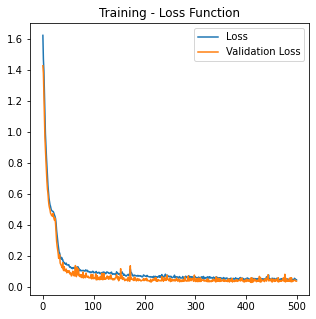

In [44]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Training (train with whole training set)

In [45]:
from transformers import XLNetConfig, TFXLNetModel
data = np.array(list(id_dict.values()))
X_train = data[:,:-1]
y_train = data[:,-1]
y_train = np.eye(5)[y_train]


config = XLNetConfig(vocab_size=15, d_model=16, n_layer=8, n_head=4, d_inner=64
                    )

xlnet = TFXLNetModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

embeddings = xlnet(input_seq)[0]
embeddings = embeddings[:, 0]

x = tf.keras.layers.Dense(32, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)
model = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
X_mask = np.ones((len(X_train),14))
history = model.fit([X_train, X_mask], y_train, batch_size=1024, epochs=500)
model.save_weights('./checkpoint_XLNet/Transformer_XLNet')

Epoch 1/500
7/7 [==============================] - 9s 349ms/step - loss: 1.5853 - accuracy: 0.3071
Epoch 2/500
7/7 [==============================] - 2s 348ms/step - loss: 1.4554 - accuracy: 0.4065
Epoch 3/500
7/7 [==============================] - 2s 350ms/step - loss: 1.3830 - accuracy: 0.4567
Epoch 4/500
7/7 [==============================] - 2s 349ms/step - loss: 1.1940 - accuracy: 0.5925
Epoch 5/500
7/7 [==============================] - 2s 348ms/step - loss: 0.9711 - accuracy: 0.6416
Epoch 6/500
7/7 [==============================] - 2s 348ms/step - loss: 0.8476 - accuracy: 0.6725
Epoch 7/500
7/7 [==============================] - 2s 349ms/step - loss: 0.7625 - accuracy: 0.7056
Epoch 8/500
7/7 [==============================] - 2s 348ms/step - loss: 0.6878 - accuracy: 0.7195
Epoch 9/500
7/7 [==============================] - 2s 349ms/step - loss: 0.6437 - accuracy: 0.7300
Epoch 10/500
7/7 [==============================] - 2s 349ms/step - loss: 0.5998 - accuracy: 0.7400
Epoch 11/

7/7 [==============================] - 2s 349ms/step - loss: 0.0728 - accuracy: 0.9773
Epoch 140/500
7/7 [==============================] - 2s 350ms/step - loss: 0.0729 - accuracy: 0.9783
Epoch 141/500
7/7 [==============================] - 2s 351ms/step - loss: 0.0690 - accuracy: 0.9783
Epoch 142/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0693 - accuracy: 0.9792
Epoch 143/500
7/7 [==============================] - 2s 346ms/step - loss: 0.0725 - accuracy: 0.9769
Epoch 144/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0724 - accuracy: 0.9769
Epoch 145/500
7/7 [==============================] - 2s 347ms/step - loss: 0.0710 - accuracy: 0.9754
Epoch 146/500
7/7 [==============================] - 2s 351ms/step - loss: 0.0716 - accuracy: 0.9777
Epoch 147/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0689 - accuracy: 0.9770
Epoch 148/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0671 - accuracy: 0.9796
Epoc

7/7 [==============================] - 2s 348ms/step - loss: 0.0509 - accuracy: 0.9845
Epoch 302/500
7/7 [==============================] - 2s 347ms/step - loss: 0.0502 - accuracy: 0.9849
Epoch 303/500
7/7 [==============================] - 2s 346ms/step - loss: 0.0524 - accuracy: 0.9843
Epoch 304/500
7/7 [==============================] - 2s 347ms/step - loss: 0.0516 - accuracy: 0.9832
Epoch 305/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0504 - accuracy: 0.9848
Epoch 306/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0480 - accuracy: 0.9851
Epoch 307/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0493 - accuracy: 0.9835
Epoch 308/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0468 - accuracy: 0.9840
Epoch 309/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0528 - accuracy: 0.9838
Epoch 310/500
7/7 [==============================] - 2s 351ms/step - loss: 0.0574 - accuracy: 0.9829
Epoc

7/7 [==============================] - 2s 347ms/step - loss: 0.0394 - accuracy: 0.9882
Epoch 464/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0450 - accuracy: 0.9858
Epoch 465/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0435 - accuracy: 0.9871
Epoch 466/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0403 - accuracy: 0.9868
Epoch 467/500
7/7 [==============================] - 2s 346ms/step - loss: 0.0384 - accuracy: 0.9871
Epoch 468/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0418 - accuracy: 0.9875
Epoch 469/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0412 - accuracy: 0.9876
Epoch 470/500
7/7 [==============================] - 2s 349ms/step - loss: 0.0414 - accuracy: 0.9875
Epoch 471/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0431 - accuracy: 0.9856
Epoch 472/500
7/7 [==============================] - 2s 348ms/step - loss: 0.0438 - accuracy: 0.9876
Epoc

Text(0.5, 1.0, 'Training - Loss Function')

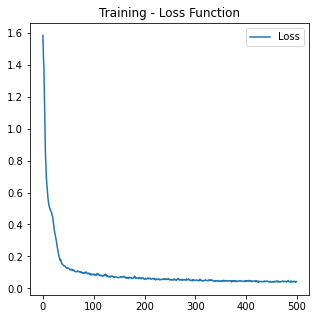

In [46]:
plt.figure(figsize=(5, 5))
plt.subplot()
plt.plot(history.history['loss'], label='Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

### Test set inference

In [47]:
X_test_mask = np.ones((len(X_test),14))
y_prob = model.predict([X_test, X_test_mask])
y_prob

108/108 [==============================] - 2s 7ms/step


array([[7.0250077e-05, 4.9036869e-04, 9.9942005e-01, 5.8276610e-06,
        1.3468104e-05],
       [5.2224317e-07, 9.7536883e-07, 9.1128601e-07, 3.3847494e-03,
        9.9661273e-01],
       [9.9999422e-01, 2.6535886e-06, 2.2957142e-06, 8.9325613e-07,
        4.6479940e-08],
       ...,
       [9.9999428e-01, 3.2391313e-06, 1.6806187e-06, 8.6096998e-07,
        4.4235225e-08],
       [4.0106032e-05, 8.9091707e-05, 9.9986315e-01, 5.6180406e-06,
        2.0288348e-06],
       [9.9999440e-01, 3.2198886e-06, 1.3595537e-06, 1.1042979e-06,
        4.5760743e-08]], dtype=float32)

In [48]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob[:,0], 'C1':y_prob[:,1], 'C2':y_prob[:,2], 'C3':y_prob[:,3], 'C4':y_prob[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,7.025008e-05,4.903687e-04,9.994200e-01,5.827661e-06,1.346810e-05
1,86e644b498922f3a2fd0e6e1a1525de3,5.222432e-07,9.753688e-07,9.112860e-07,3.384749e-03,9.966127e-01
2,691662b04ee08015062d901a4c5628b1,9.999942e-01,2.653589e-06,2.295714e-06,8.932561e-07,4.647994e-08
3,52b5c510a28774237f4f118764c2ed6f,1.680964e-04,9.996778e-01,2.268377e-05,1.306366e-04,8.692384e-07
4,9f3c995e53d109f532056b6eae29a0b5,4.433210e-05,1.598631e-02,9.838040e-01,8.713668e-05,7.806838e-05
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,9.999944e-01,3.110032e-06,1.399284e-06,1.078556e-06,4.705225e-08
3425,f1c8781e701e89068fa0b8a62ecbc564,8.473531e-07,2.341644e-06,1.235653e-06,1.770269e-03,9.982253e-01
3426,646136b402e136422466a2acd8636630,9.999943e-01,3.239131e-06,1.680619e-06,8.609700e-07,4.423523e-08
3427,c7bea6491029f86ab3d1f0f9b599ca2c,4.010603e-05,8.909171e-05,9.998631e-01,5.618041e-06,2.028835e-06


In [49]:
output.to_csv("output_transformer_XLNet.csv", index=False)

# <font color=#FF0000> Data preprocess (w/ group)</font> 	

In [50]:
group_id_dict = {m: [] for m in id_list}

group_1 = dict()
group_2 = dict()
group_3 = dict()
group_4 = dict()

for data in list(train_data.values):
    loc = data[1]
    group_id_dict[data[0]].append(loc)

## 1~2
## 3~7
## 8~14
for k, v in group_id_dict.items():
    if 1 <= len(v) <= 2:
        group_1[k] = [0] * (2 - len(v)) + v
        group_1[k].append(label_dict[k])
    elif 3 <= len(v) <= 7:
        # padding
        group_2[k] = [0] * (7 - len(v)) + v
        group_2[k].append(label_dict[k])
    elif 8 <= len(v) <= 14:
        # padding
        group_3[k] = [0] * (14 - len(v)) + v
        group_3[k].append(label_dict[k])
        
data = np.array(list(group_1.values()))
X_train_1 = data[:,:-1]
y_train_1 = data[:,-1]

data = np.array(list(group_2.values()))
X_train_2 = data[:,:-1]
y_train_2 = data[:,-1]

data = np.array(list(group_3.values()))
X_train_3 = data[:,:-1]
y_train_3 = data[:,-1]

# <font color=#FF0000> Catboost (w/ group)</font> 	

### Training (with cross validation)

In [51]:
acc_1 = 100
model_2 = CatBoostClassifier(loss_function='MultiClass', verbose=0)
result = cross_validate(model_2, X_train_2, y_train_2, cv=5, verbose=3)
acc_2 = result['test_score'].mean()*100
print('Group 2 cross validation mean accuracy:', acc_2)
model_3 = CatBoostClassifier(loss_function='MultiClass', verbose=0)
result = cross_validate(model_3, X_train_3, y_train_3, cv=5, verbose=3)
acc_3 = result['test_score'].mean()*100
print('Group 3 cross validation mean accuracy:', acc_3)

#model = CatBoostClassifier(iterations=1000,learning_rate=0.1,max_depth=7,verbose=100,
#                           early_stopping_rounds=500,task_type='GPU',eval_metric='AUC')

print('All group mean cross validation accuracy:', 
      (acc_1*len(group_1)+acc_2*len(group_2)+acc_3*len(group_3))/
      (len(group_1)+len(group_2)+len(group_3)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/leo/anaconda3/envs/MLtest/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ......................................., score=0.944 total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ......................................., score=0.939 total time=   0.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ......................................., score=0.941 total time=   0.5s
[CV] END ......................................., score=0.936 total time=   0.5s
[CV] END ......................................., score=0.947 total time=   0.5s
Group 2 cross validation mean accuracy: 94.12064171122994


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.922 total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ......................................., score=0.937 total time=   0.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END ......................................., score=0.953 total time=   0.8s
[CV] END ......................................., score=0.946 total time=   0.8s
[CV] END ......................................., score=0.942 total time=   0.8s
Group 3 cross validation mean accuracy: 93.99037522667038
All group mean cross validation accuracy: 96.10575310733743


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished


### Training (train with  whole training set)

In [52]:
model_2 = CatBoostClassifier(loss_function='MultiClass')
model_2.fit(X_train_2, y_train_2, verbose=0)
model_3 = CatBoostClassifier(loss_function='MultiClass')
model_3.fit(X_train_3, y_train_3, verbose=0)

y_pred_1 = np.zeros((len(group_1), 1), dtype=int)
y_pred_2 = model_2.predict(X_train_2)
y_pred_3 = model_3.predict(X_train_3)

y_pred_group = np.concatenate((y_pred_1, y_pred_2, y_pred_3), axis=0)

y_train_group = np.concatenate((y_train_1, y_train_2, y_train_3), axis=0)
print('Training set accuracy:', accuracy_score(y_train_group, y_pred_group))

Training set accuracy: 0.9998563011927001


### Test set inference

In [53]:
group_id_dict = {m: [] for m in id_list_test}

for data in list(test_data.values):
    loc = data[1]
    group_id_dict[data[0]].append(loc)

i = 0
y_prob_group = np.zeros((3429,5))
for k, v in group_id_dict.items():
    if 1 <= len(v) <= 2:
        X = [0] * (2 - len(v)) + v
        y_prob_group[i] = [1,0,0,0,0]
    elif 3 <= len(v) <= 7:
        # padding
        X = [0] * (7 - len(v)) + v
        y_prob_group[i][0:4] = model_2.predict_proba(X)
    elif 8 <= len(v) <= 14:
        # padding
        X = [0] * (14 - len(v)) + v
        y_prob_group[i][1:] = model_3.predict_proba(X)
    i += 1

In [54]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob_group[:,0], 'C1':y_prob_group[:,1], 'C2':y_prob_group[:,2], 'C3':y_prob_group[:,3], 'C4':y_prob_group[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,0.102879,0.027298,0.869613,0.000210,0.000000
1,86e644b498922f3a2fd0e6e1a1525de3,0.000000,0.000006,0.000078,0.007759,0.992156
2,691662b04ee08015062d901a4c5628b1,1.000000,0.000000,0.000000,0.000000,0.000000
3,52b5c510a28774237f4f118764c2ed6f,0.000926,0.999068,0.000001,0.000005,0.000000
4,9f3c995e53d109f532056b6eae29a0b5,0.000705,0.040785,0.955921,0.002588,0.000000
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,1.000000,0.000000,0.000000,0.000000,0.000000
3425,f1c8781e701e89068fa0b8a62ecbc564,0.000000,0.000017,0.000479,0.013290,0.986214
3426,646136b402e136422466a2acd8636630,1.000000,0.000000,0.000000,0.000000,0.000000
3427,c7bea6491029f86ab3d1f0f9b599ca2c,0.007019,0.000069,0.992889,0.000023,0.000000


In [55]:
output.to_csv("output_Catboost_group.csv", index=False)

# <font color=#FF0000> Transformer BERT (w/ group)</font> 	

### Training (with validation set spiltted from training set)

In [56]:
y_train_2_onehot = np.eye(4)[y_train_2]
y_train_3_onehot = np.eye(4)[y_train_3 - 1]

In [57]:
config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(7,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(7,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(x)

model_2 = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model_2.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [58]:
X_mask_2 = np.ones((len(X_train_2),7))
model_2.fit([X_train_2, X_mask_2], y_train_2_onehot, batch_size=512, epochs=100, validation_split=0.1)

Epoch 1/100
4/4 [==============================] - 12s 673ms/step - loss: 1.0616 - accuracy: 0.5003 - val_loss: 1.0138 - val_accuracy: 0.5106
Epoch 2/100
4/4 [==============================] - 0s 70ms/step - loss: 1.0018 - accuracy: 0.5270 - val_loss: 0.9915 - val_accuracy: 0.5319
Epoch 3/100
4/4 [==============================] - 0s 69ms/step - loss: 0.9863 - accuracy: 0.5342 - val_loss: 0.9804 - val_accuracy: 0.5266
Epoch 4/100
4/4 [==============================] - 0s 68ms/step - loss: 0.9605 - accuracy: 0.5383 - val_loss: 0.9572 - val_accuracy: 0.5266
Epoch 5/100
4/4 [==============================] - 0s 69ms/step - loss: 0.9386 - accuracy: 0.5431 - val_loss: 0.9125 - val_accuracy: 0.5266
Epoch 6/100
4/4 [==============================] - 0s 68ms/step - loss: 0.8911 - accuracy: 0.5472 - val_loss: 0.8258 - val_accuracy: 0.5798
Epoch 7/100
4/4 [==============================] - 0s 68ms/step - loss: 0.7893 - accuracy: 0.6583 - val_loss: 0.6723 - val_accuracy: 0.7766
Epoch 8/100
4/4 [=

In [59]:
config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(x)

model_3 = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model_3.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [60]:
X_mask_3 = np.ones((len(X_train_3),14))
model_3.fit([X_train_3, X_mask_3], y_train_3_onehot, batch_size=512, epochs=100, validation_split=0.1)

Epoch 1/100
5/5 [==============================] - 12s 588ms/step - loss: 1.1736 - accuracy: 0.5010 - val_loss: 1.0069 - val_accuracy: 0.6157
Epoch 2/100
5/5 [==============================] - 1s 137ms/step - loss: 1.0308 - accuracy: 0.5981 - val_loss: 0.9731 - val_accuracy: 0.6493
Epoch 3/100
5/5 [==============================] - 1s 136ms/step - loss: 0.9965 - accuracy: 0.6242 - val_loss: 0.9441 - val_accuracy: 0.6828
Epoch 4/100
5/5 [==============================] - 1s 135ms/step - loss: 0.9714 - accuracy: 0.6454 - val_loss: 0.9299 - val_accuracy: 0.6903
Epoch 5/100
5/5 [==============================] - 1s 137ms/step - loss: 0.9553 - accuracy: 0.6487 - val_loss: 0.9068 - val_accuracy: 0.6903
Epoch 6/100
5/5 [==============================] - 1s 136ms/step - loss: 0.9411 - accuracy: 0.6483 - val_loss: 0.8888 - val_accuracy: 0.6903
Epoch 7/100
5/5 [==============================] - 1s 136ms/step - loss: 0.9285 - accuracy: 0.6487 - val_loss: 0.8650 - val_accuracy: 0.6903
Epoch 8/100


### Training (train with  whole training set)

In [61]:
config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(7,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(7,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(x)

model_2 = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model_2.compile(optimizer=optimizer, loss=loss, metrics=[acc])

X_mask_2 = np.ones((len(X_train_2),7))
model_2.fit([X_train_2, X_mask_2], y_train_2_onehot, batch_size=512, epochs=100)

Epoch 1/100
4/4 [==============================] - 10s 68ms/step - loss: 1.2807 - accuracy: 0.4046
Epoch 2/100
4/4 [==============================] - 0s 66ms/step - loss: 1.0863 - accuracy: 0.5238
Epoch 3/100
4/4 [==============================] - 0s 86ms/step - loss: 1.0214 - accuracy: 0.5382
Epoch 4/100
4/4 [==============================] - 0s 66ms/step - loss: 0.9868 - accuracy: 0.5361
Epoch 5/100
4/4 [==============================] - 0s 77ms/step - loss: 0.9529 - accuracy: 0.5409
Epoch 6/100
4/4 [==============================] - 0s 66ms/step - loss: 0.8922 - accuracy: 0.5879
Epoch 7/100
4/4 [==============================] - 0s 65ms/step - loss: 0.7911 - accuracy: 0.7119
Epoch 8/100
4/4 [==============================] - 0s 67ms/step - loss: 0.6468 - accuracy: 0.7819
Epoch 9/100
4/4 [==============================] - 0s 66ms/step - loss: 0.5363 - accuracy: 0.7889
Epoch 10/100
4/4 [==============================] - 0s 66ms/step - loss: 0.4802 - accuracy: 0.8172
Epoch 11/100
4/4 [

In [62]:
config = BertConfig(vocab_size=15, hidden_size=16, num_hidden_layer=8, num_attention_heads=4,
                    intermediate_size=64, max_position_embeddings=14)
bert = TFBertModel(config)

input_seq = tf.keras.layers.Input(shape=(14,), name='input_seq', dtype='int32')
mask = tf.keras.layers.Input(shape=(14,), name='attention_mask', dtype='int32')

encoder = bert(input_seq, attention_mask=mask)[0][:,0] 

x = tf.keras.layers.Dense(32, activation='relu')(encoder)
y = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(x)

model_3 = tf.keras.Model(inputs=[input_seq, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model_3.compile(optimizer=optimizer, loss=loss, metrics=[acc])

X_mask_3 = np.ones((len(X_train_3),14))
model_3.fit([X_train_3, X_mask_3], y_train_3_onehot, batch_size=512, epochs=100)

Epoch 1/100
6/6 [==============================] - 11s 119ms/step - loss: 1.5101 - accuracy: 0.2307
Epoch 2/100
6/6 [==============================] - 1s 117ms/step - loss: 1.1558 - accuracy: 0.4602
Epoch 3/100
6/6 [==============================] - 1s 117ms/step - loss: 1.0372 - accuracy: 0.5916
Epoch 4/100
6/6 [==============================] - 1s 117ms/step - loss: 1.0098 - accuracy: 0.5913
Epoch 5/100
6/6 [==============================] - 1s 117ms/step - loss: 1.0010 - accuracy: 0.5920
Epoch 6/100
6/6 [==============================] - 1s 116ms/step - loss: 0.9932 - accuracy: 0.6028
Epoch 7/100
6/6 [==============================] - 1s 117ms/step - loss: 0.9782 - accuracy: 0.6170
Epoch 8/100
6/6 [==============================] - 1s 116ms/step - loss: 0.9661 - accuracy: 0.6390
Epoch 9/100
6/6 [==============================] - 1s 117ms/step - loss: 0.9389 - accuracy: 0.6510
Epoch 10/100
6/6 [==============================] - 1s 117ms/step - loss: 0.8891 - accuracy: 0.6607
Epoch 11

Epoch 78/100
6/6 [==============================] - 1s 119ms/step - loss: 0.0941 - accuracy: 0.9750
Epoch 79/100
6/6 [==============================] - 1s 117ms/step - loss: 0.1089 - accuracy: 0.9672
Epoch 80/100
6/6 [==============================] - 1s 119ms/step - loss: 0.0976 - accuracy: 0.9713
Epoch 81/100
6/6 [==============================] - 1s 117ms/step - loss: 0.1047 - accuracy: 0.9672
Epoch 82/100
6/6 [==============================] - 1s 118ms/step - loss: 0.1082 - accuracy: 0.9664
Epoch 83/100
6/6 [==============================] - 1s 118ms/step - loss: 0.0965 - accuracy: 0.9690
Epoch 84/100
6/6 [==============================] - 1s 118ms/step - loss: 0.0991 - accuracy: 0.9698
Epoch 85/100
6/6 [==============================] - 1s 117ms/step - loss: 0.0944 - accuracy: 0.9720
Epoch 86/100
6/6 [==============================] - 1s 117ms/step - loss: 0.0931 - accuracy: 0.9705
Epoch 87/100
6/6 [==============================] - 1s 117ms/step - loss: 0.1038 - accuracy: 0.9675


### Test set inference

In [63]:
group_id_dict = {m: [] for m in id_list_test}

for data in list(test_data.values):
    loc = data[1]
    group_id_dict[data[0]].append(loc)

i = 0
y_prob_group = np.zeros((3429,5))
for k, v in group_id_dict.items():
    if(i % 1000 == 0): print(i)
    if 1 <= len(v) <= 2:
        X = [0] * (2 - len(v)) + v
        y_prob_group[i] = [1,0,0,0,0]
    elif 3 <= len(v) <= 7:
        # padding
        X = [0] * (7 - len(v)) + v
        X_test_mask = np.ones(7)
        y_prob_group[i][0:4] = model_2.predict([np.array([X,]), np.array([X_test_mask,])], verbose=0)
    elif 8 <= len(v) <= 14:
        # padding
        X = [0] * (14 - len(v)) + v
        X_test_mask = np.ones(14)
        y_prob_group[i][1:] = model_3.predict([np.array([X,]), np.array([X_test_mask,])], verbose=0)
    i += 1

0
1000
2000
3000


In [64]:
output = pd.DataFrame({'mac_hash':sample['mac_hash'], 'C0':y_prob_group[:,0], 'C1':y_prob_group[:,1], 'C2':y_prob_group[:,2], 'C3':y_prob_group[:,3], 'C4':y_prob_group[:,4]})
output

,mac_hash,C0,C1,C2,C3,C4
0,b882f1d44602a25349a08f4a0af32977,0.001084,0.000386,0.998355,0.000175,0.000000
1,86e644b498922f3a2fd0e6e1a1525de3,0.000000,0.001393,0.000048,0.001234,0.997326
2,691662b04ee08015062d901a4c5628b1,1.000000,0.000000,0.000000,0.000000,0.000000
3,52b5c510a28774237f4f118764c2ed6f,0.001322,0.997899,0.000107,0.000672,0.000000
4,9f3c995e53d109f532056b6eae29a0b5,0.000921,0.049677,0.948676,0.000726,0.000000
...,...,...,...,...,...,...
3424,5001c0dfe522886ed884c0dc4e5848df,1.000000,0.000000,0.000000,0.000000,0.000000
3425,f1c8781e701e89068fa0b8a62ecbc564,0.000000,0.000105,0.000098,0.010149,0.989648
3426,646136b402e136422466a2acd8636630,1.000000,0.000000,0.000000,0.000000,0.000000
3427,c7bea6491029f86ab3d1f0f9b599ca2c,0.000358,0.000137,0.999350,0.000155,0.000000


In [65]:
output.to_csv("output_transformer_bert_group.csv", index=False)